In [1]:
%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     AveragePooling2D, 
                                     Dense, 
                                     Dropout, 
                                     Flatten)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
sns.set_style('whitegrid')

In [4]:
results_path = Path('results')
mnist_path = results_path / 'mnist'
if not mnist_path.exists():
    mnist_path.mkdir(parents=True)

#Carichiamo il MNIST dataset

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("The MNIST database has a training set of %d examples." % len(X_train))
print("The MNIST database has a test set of %d examples." % len(X_test))

11490434/11490434 [==============================] - 0s 0us/step
The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


In [6]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

#Visualize Data

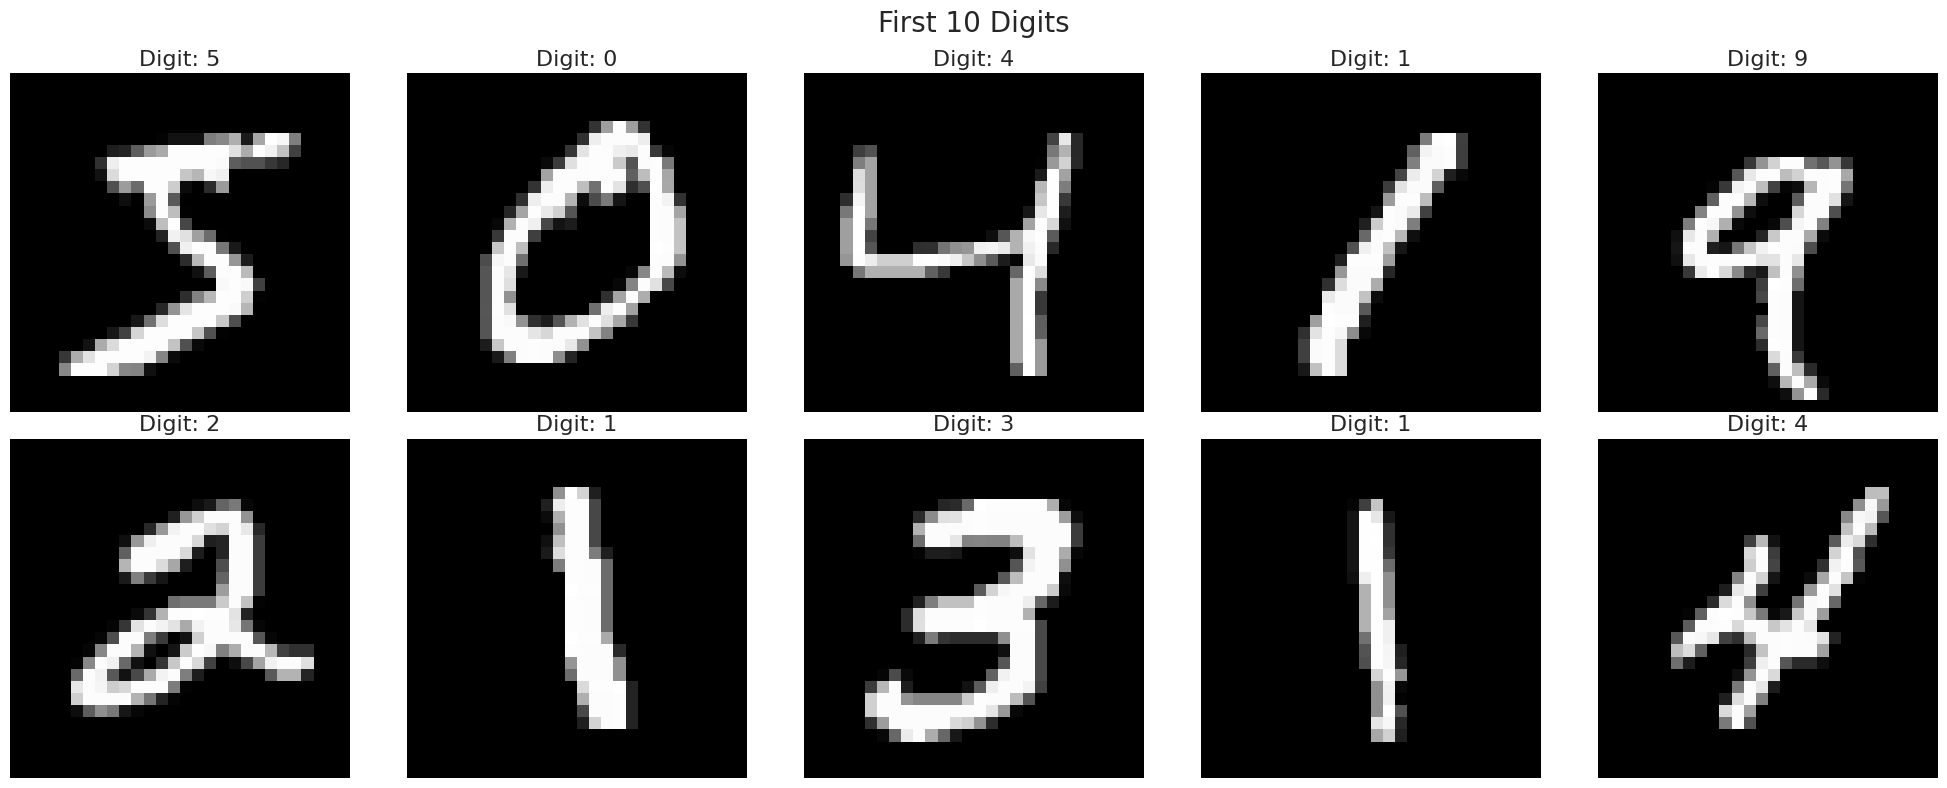

In [7]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')
    ax.set_title('Digit: {}'.format(y_train[i]), fontsize=16)
fig.suptitle('First 10 Digits', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)

Mostriamo un'immagine a caso in dettaglio

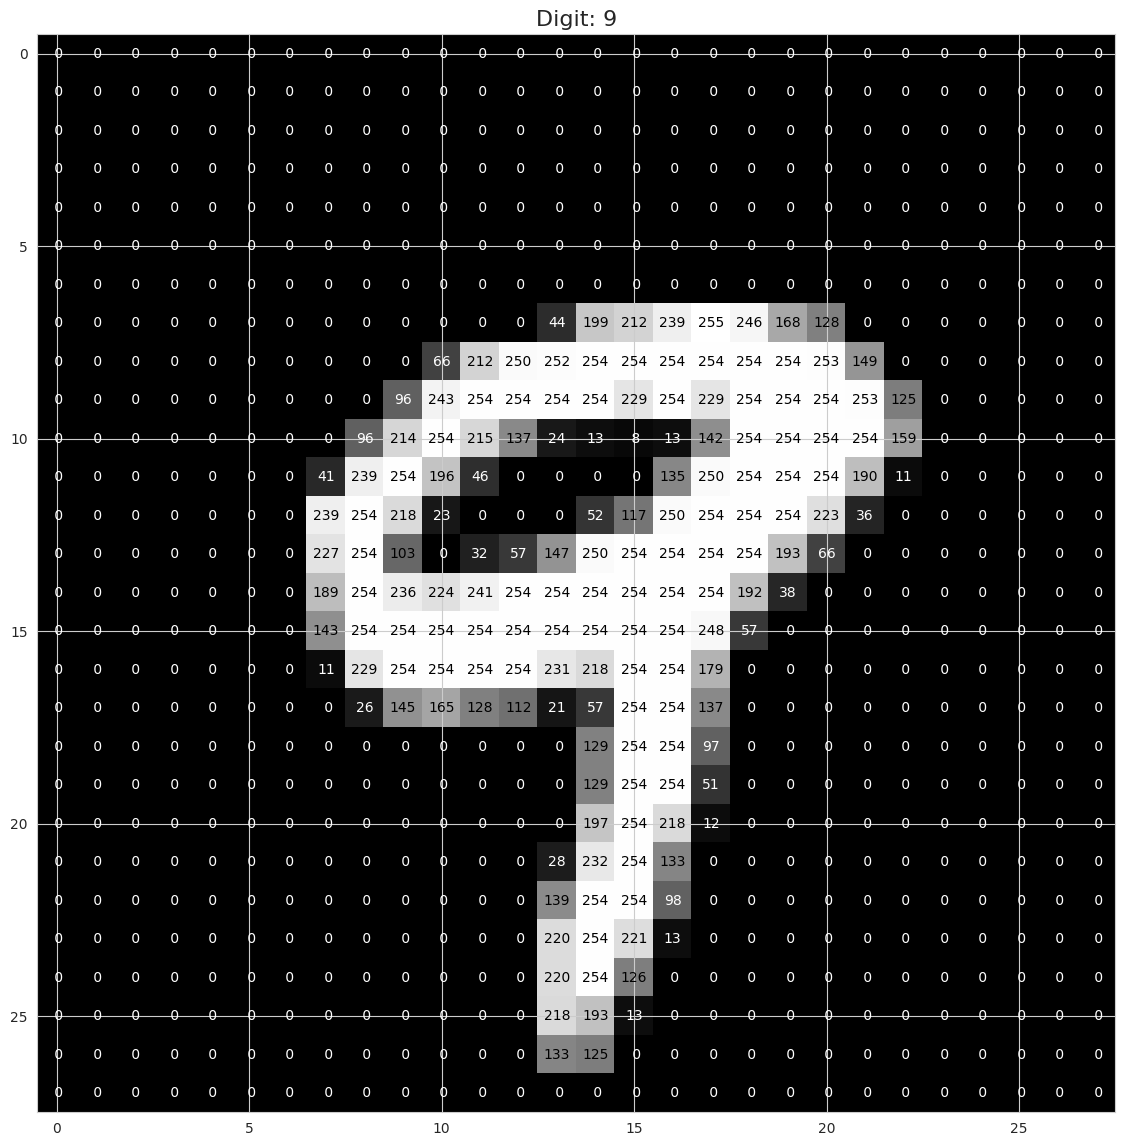

In [8]:
fig, ax = plt.subplots(figsize = (14, 14)) 

i = randint(0, len(X_train))
img = X_train[i]

ax.imshow(img, cmap='gray')
ax.set_title('Digit: {}'.format(y_train[i]), fontsize=16)

width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        ax.annotate('{:2}'.format(img[x][y]), 
                    xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

#Prepare Data

In [9]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255 

#Feed-forward NN

In [10]:
#architettura del modello

ffnn = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

In [11]:
ffnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trai

In [12]:
#compiliamo il modello
ffnn.compile(loss='sparse_categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

In [13]:
#calcoliamo l'accuratezza della classificazione di base
# evaluate test accuracy
baseline_accuracy = ffnn.evaluate(X_test, y_test, verbose=0)[1]

# print test accuracy
print(f'Test accuracy: {baseline_accuracy:.2%}')

Test accuracy: 10.38%


callback per la persistenza del modello

In [14]:
ffn_path = mnist_path / 'ffn.best.hdf5'
checkpointer = ModelCheckpoint(filepath=ffn_path.as_posix(), 
                               verbose=1, 
                               save_best_only=True)

In [15]:
#callback con arresto anticipato
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

Addestriamo il modello

In [16]:
epochs = 100
batch_size = 32

In [17]:
ffnn_history = ffnn.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.2,
                        callbacks=[checkpointer, early_stopping],
                        verbose=1,
                        shuffle=True)

Epoch 1/100
1500/1500 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9274
Epoch 1: val_loss improved from inf to 0.12106, saving model to results/mnist/ffn.best.hdf5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2385 - accuracy: 0.9274 - val_loss: 0.1211 - val_accuracy: 0.9655
Epoch 2/100
1497/1500 [============================>.] - ETA: 0s - loss: 0.1187 - accuracy: 0.9659
Epoch 2: val_loss improved from 0.12106 to 0.10666, saving model to results/mnist/ffn.best.hdf5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.1185 - accuracy: 0.9659 - val_loss: 0.1067 - val_accuracy: 0.9710
Epoch 3/100
1499/1500 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9746
Epoch 3: val_loss did not improve from 0.10666
1500/1500 [==============================] - 19s 13ms/step - loss: 0.0961 - accuracy: 0.9746 - val_loss: 0.1111 - val_accuracy: 0.9710
Epoch 4/100
1496/1500 [============================>.] - ETA: 0

#Grafici dei risulati

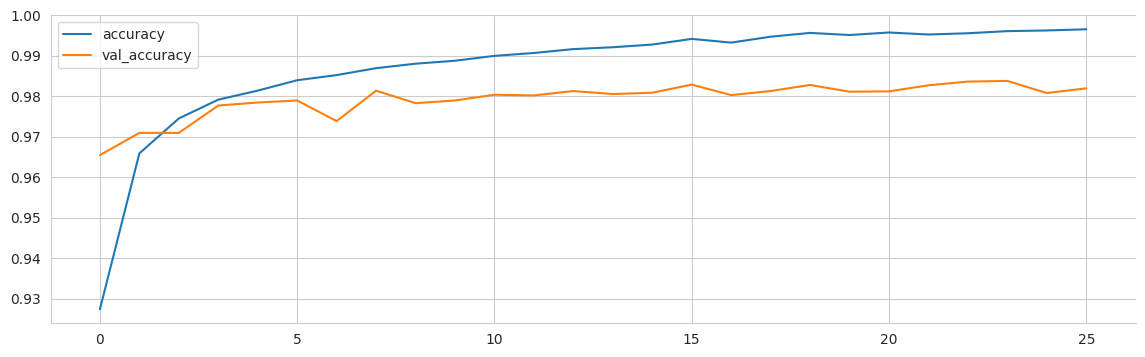

In [19]:
pd.DataFrame(ffnn_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14,4))
sns.despine();

In [20]:
#carichiamo i pesi che hanno prodotto la miglior validation accuracy
ffnn.load_weights(ffn_path.as_posix())

In [21]:
#accuratezza della classificazione dei test
ffnn_accuracy = ffnn.evaluate(X_test, y_test, verbose=0)[1]

print(f'Test accuracy: {ffnn_accuracy:.2%}')

Test accuracy: 97.97%


#LeNet5

In [22]:
K.clear_session()

lenet5 = Sequential([
    Conv2D(filters=6,
           kernel_size=5,
           activation='relu',
           input_shape=(28, 28, 1),
           name='CONV1'),
    AveragePooling2D(pool_size=(2, 2),
                     strides=(1, 1),
                     padding='valid',
                     name='POOL1'),
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', name='CONV2'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL2'),
    Conv2D(filters=120, kernel_size=(5, 5), activation='tanh', name='CONV3'),
    Flatten(name='FLAT'),
    Dense(units=84, activation='tanh', name='FC6'),
    Dense(units=10, activation='softmax', name='FC7')
])

In [23]:
lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 24, 24, 6)         156       
                                                                 
 POOL1 (AveragePooling2D)    (None, 23, 23, 6)         0         
                                                                 
 CONV2 (Conv2D)              (None, 19, 19, 16)        2416      
                                                                 
 POOL2 (AveragePooling2D)    (None, 9, 9, 16)          0         
                                                                 
 CONV3 (Conv2D)              (None, 5, 5, 120)         48120     
                                                                 
 FLAT (Flatten)              (None, 3000)              0         
                                                                 
 FC6 (Dense)                 (None, 84)                2

In [24]:
lenet5.compile(loss='sparse_categorical_crossentropy',
               optimizer='SGD',
               metrics=['accuracy'])

In [25]:
lenet_path = mnist_path / 'lenet.best.hdf5'
checkpointer = ModelCheckpoint(filepath=lenet_path.as_posix(),
                               verbose=1,
                               save_best_only=True)

#Train Model

In [26]:
batch_size=32
epochs=100

lenet_history = lenet5.fit(
    X_train.reshape(-1, 28, 28, 1),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  # use 0 to train on all data
    callbacks=[checkpointer, early_stopping],
    verbose=1,
    shuffle=True)

Epoch 1/100
1500/1500 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8712
Epoch 1: val_loss improved from inf to 0.22928, saving model to results/mnist/lenet.best.hdf5
1500/1500 [==============================] - 66s 44ms/step - loss: 0.4637 - accuracy: 0.8712 - val_loss: 0.2293 - val_accuracy: 0.9362
Epoch 2/100
1500/1500 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9432
Epoch 2: val_loss improved from 0.22928 to 0.15603, saving model to results/mnist/lenet.best.hdf5
1500/1500 [==============================] - 62s 41ms/step - loss: 0.1991 - accuracy: 0.9432 - val_loss: 0.1560 - val_accuracy: 0.9567
Epoch 3/100
1499/1500 [============================>.] - ETA: 0s - loss: 0.1415 - accuracy: 0.9600
Epoch 3: val_loss improved from 0.15603 to 0.11584, saving model to results/mnist/lenet.best.hdf5
1500/1500 [==============================] - 58s 39ms/step - loss: 0.1415 - accuracy: 0.9600 - val_loss: 0.1158 - val_accuracy: 0.9675
Epoch 4/

#Plot dei risulatati

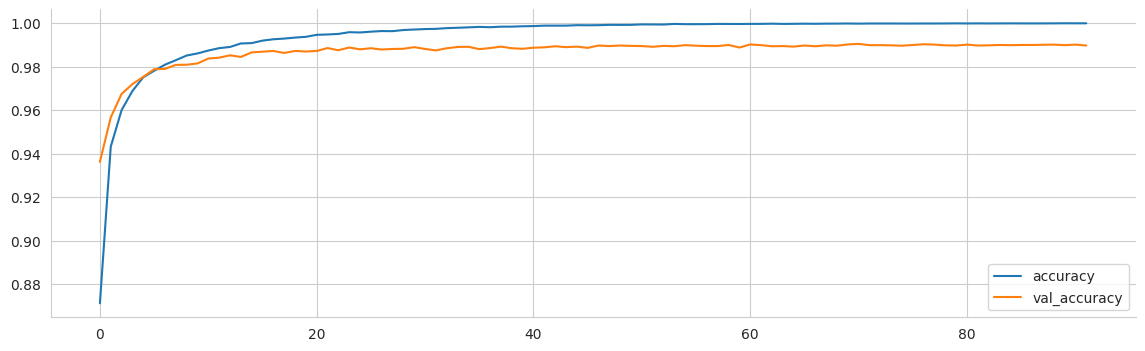

In [27]:
pd.DataFrame(lenet_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14,4))
sns.despine();

In [28]:
#accuratezza della classificazione dei test
lenet_accuracy = lenet5.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(lenet_accuracy))

Test accuracy: 99.04%
